# GCNConv Model Evaluation

In [2]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv


## Importing the data

In [3]:
# Produce SMILES strings from CAS numbers
# df = resolve_smiles_by_cas_interactive("data/raw/Ozkan_data_2024.xlsx", "data/processed/input.csv")

# Convert smiles strings in the CSV file to a list of PyTorch graphs
graph_list = batch_from_csv("data/processed/input.csv")
molecules_df = pd.read_csv("data/processed/input.csv")


In [4]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


In [5]:
graph_list[0].x.shape, graph_list[0].edge_index.shape

(torch.Size([8, 79]), torch.Size([2, 16]))

In [6]:
graph_list[0].y

tensor([5.2900])

## Model Training and Prediction Eval Functions

In [7]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


In [8]:
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader

train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)


def train_gcn_model_batched(dataloader, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch).squeeze()
            target = batch.y.squeeze()

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model



In [9]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_predictions(dataloader, model):
    """
    Function to plot predictions vs actual values.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_preds, alpha=0.7)
    plt.plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs. Actual - GCN Model (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
import plotly
plotly.__version__

'6.2.0'

In [11]:
molecules_df.head()

,Inhibitor Name,CAS Number,Inh Power,SMILES
0,1-H-imidazole-2-carboxylic acid,16042-25-4,5.29,C1=CN=C(N1)C(=O)O
1,1-methyl-1-H-benzimidazole-2-thiol,2360-22-7,10.04,CN1C2=CC=CC=C2NC1=S
2,1-methyl-benzimidazole,1632-83-3,-0.51,CN1C=NC2=CC=CC=C21
3,"1,2,4-triazole",288-88-0,2.09,C1=NC=NN1
4,"1,3-diisopropyl-2-thiourea",2986-17-6,3.54,CC(C)NC(=S)NC(C)C


In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    all_preds = []
    all_targets = []

    # Put model in eval mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Flatten
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - GCNModel (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()



In [13]:
molecules_df.columns

Index(['Inhibitor Name', 'CAS Number', 'Inh Power', 'SMILES'], dtype='object')

## Model Creation

In [14]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)


        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [15]:
model = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model)

GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training the model

In [16]:
train_gcn_model_batched(graph_list, model, lr=1e-3, epochs=300)

Epoch 1, Loss: 2761.4216
Epoch 2, Loss: 2535.0513
Epoch 3, Loss: 2376.9686
Epoch 4, Loss: 2285.3137
Epoch 5, Loss: 2175.5567
Epoch 6, Loss: 2123.5162
Epoch 7, Loss: 2101.1372
Epoch 8, Loss: 2025.9973
Epoch 9, Loss: 2053.9381
Epoch 10, Loss: 2056.4432
Epoch 11, Loss: 1982.0856
Epoch 12, Loss: 1870.6318
Epoch 13, Loss: 1753.6627
Epoch 14, Loss: 1757.2181
Epoch 15, Loss: 1719.9535
Epoch 16, Loss: 1686.0973
Epoch 17, Loss: 1644.3360
Epoch 18, Loss: 1564.9788
Epoch 19, Loss: 1526.7749
Epoch 20, Loss: 1548.4154
Epoch 21, Loss: 1584.2922
Epoch 22, Loss: 1470.6953
Epoch 23, Loss: 1411.9083
Epoch 24, Loss: 1451.0974
Epoch 25, Loss: 1384.3852
Epoch 26, Loss: 1483.7467
Epoch 27, Loss: 1357.9076
Epoch 28, Loss: 1369.5560
Epoch 29, Loss: 1386.9637
Epoch 30, Loss: 1462.7428
Epoch 31, Loss: 1288.2311
Epoch 32, Loss: 1295.3935
Epoch 33, Loss: 1343.1167
Epoch 34, Loss: 1315.8689
Epoch 35, Loss: 1311.0746
Epoch 36, Loss: 1338.2703
Epoch 37, Loss: 1269.0725
Epoch 38, Loss: 1245.3244
Epoch 39, Loss: 1269.

GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Evaluating model accuracy

R² score: 0.828
RMSE: 2.351


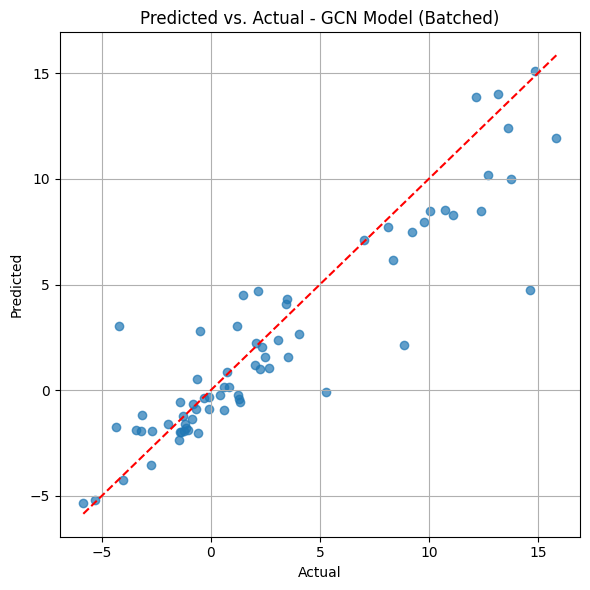

In [17]:
plot_predictions(graph_list, model)

In [ ]:
# Create unshuffled evaluation loader so that data labels match the correct graph
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.828
RMSE: 2.351


## UMAP Dimensionality Reduction

In [97]:
import torch
import umap
import pandas as pd
import plotly.express as px

# Store everything
all_embeddings = []
all_labels = []

# Model in eval mode
model.eval()
with torch.no_grad():
    for batch in eval_loader:
        emb = model(batch.x, batch.edge_index, batch=batch.batch)
        all_embeddings.append(emb.cpu())
        all_labels.append(batch.y.cpu())

# Stack them
embeddings = torch.cat(all_embeddings, dim=0).numpy()  # shape: (70, hidden_dim)
labels = torch.cat(all_labels, dim=0).numpy()          # shape: (70,)


In [98]:
embeddings.shape, labels.shape
# Both should be (70, )

((70, 1), (70,))

In [99]:
# Create 2D embeddings for plotly plot
reducer = umap.UMAP(n_components=2, random_state=123)
embeddings_2d = reducer.fit_transform(embeddings)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [100]:
df = pd.DataFrame({
    "UMAP1": embeddings_2d[:,0],
    "UMAP2": embeddings_2d[:,1],
    "Label": labels
})

# If you also have names/SMILES:
df["Inhibitor"] = molecules_df["Inhibitor Name"]
df

,UMAP1,UMAP2,Label,Inhibitor
0,4.181657,8.754805,5.29,1-H-imidazole-2-carboxylic acid
1,14.490342,10.084476,10.04,1-methyl-1-H-benzimidazole-2-thiol
2,7.333139,6.893381,-0.51,1-methyl-benzimidazole
3,7.043718,7.234773,2.09,"1,2,4-triazole"
4,6.288222,7.473650,3.54,"1,3-diisopropyl-2-thiourea"
...,...,...,...,...
65,7.677633,7.039293,1.19,Thiosalycylic acid
66,6.072016,7.789485,2.68,Thiourea
67,1.366950,9.778565,-0.88,Triisoproponalamine
68,-2.749650,11.357094,-5.85,Tryptamine


In [101]:
fig = px.scatter(
    df,
    x="UMAP1",
    y="UMAP2",
    color="Label",
    hover_data={
        "Inhibitor": True,
        "Label": ':.2f'
    },
    title="UMAP projection of GNN graph embeddings"
)
fig.show()


In [ ]:
#TODO:[Chiara] From this:
# • Where are the outliers in the GNN pareto plot in this graph? I suppose they’ll be in the trailing bit….
# • What are the common chemical properties in the two clusters? Can you extract the molecule name/SMILE for a couple of molecules in the bottom right and a couple for the top left cluster.

In [85]:
from rdkit import Chem
from rdkit.Chem import AllChem
smiles = molecules_df["SMILES"].iloc[0]
mol = Chem.MolFromSmiles(smiles)

# Generate ECFP4 fingerprint (radius 2)
ecfp4_fingerprint = AllChem.GetMorganFingerprint(mol, 2)

ecfp4_fingerprint

[21:47:11] DEPRECATION WARNING: please use MorganGenerator


## Predicting an arbitrary molcule

In [22]:
def visualize_graph(G, color=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



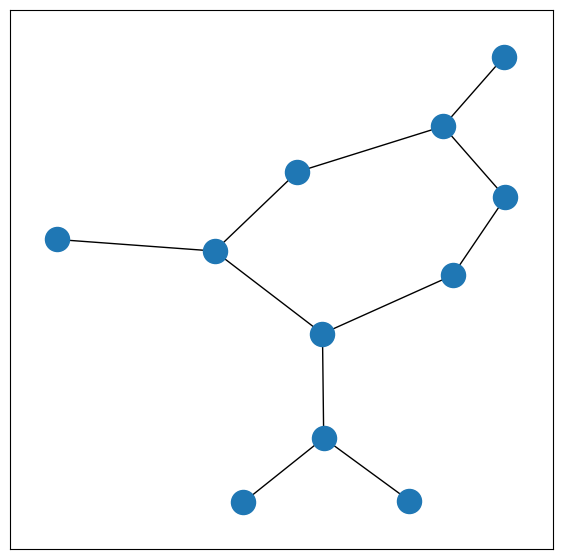

In [23]:
G = to_networkx(graph_list[23], to_undirected=True)
visualize_graph(G)

In [24]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y 

tensor([1.2800])

In [25]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(
            batch.x, batch.edge_index, batch.batch
        )

        return round(prediction.item(), 4)
predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

-0.4253

## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


### Number of layers


#### 2 Layers

In [90]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel2L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)


        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [91]:
model_2L = GCNModel2L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_2L)

GCNModel2L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 135.8334
Epoch 2, Loss: 160.8949
Epoch 3, Loss: 155.4000
Epoch 4, Loss: 136.4318
Epoch 5, Loss: 119.5438
Epoch 6, Loss: 131.3921
Epoch 7, Loss: 137.0284
Epoch 8, Loss: 105.3147
Epoch 9, Loss: 90.3805
Epoch 10, Loss: 115.4113
Epoch 11, Loss: 106.6028
Epoch 12, Loss: 121.5241
Epoch 13, Loss: 73.1870
Epoch 14, Loss: 75.8134
Epoch 15, Loss: 105.5351
Epoch 16, Loss: 108.0355
Epoch 17, Loss: 85.9200
Epoch 18, Loss: 92.2298
Epoch 19, Loss: 88.1929
Epoch 20, Loss: 102.8988
Epoch 21, Loss: 94.8324
Epoch 22, Loss: 80.1367
Epoch 23, Loss: 85.6638
Epoch 24, Loss: 83.4097
Epoch 25, Loss: 107.2591
Epoch 26, Loss: 108.2785
Epoch 27, Loss: 95.6988
Epoch 28, Loss: 86.6407
Epoch 29, Loss: 76.9088
Epoch 30, Loss: 76.9716
Epoch 31, Loss: 84.6391
Epoch 32, Loss: 82.1219
Epoch 33, Loss: 76.1342
Epoch 34, Loss: 81.8871
Epoch 35, Loss: 106.4530
Epoch 36, Loss: 68.1129
Epoch 37, Loss: 93.9910
Epoch 38, Loss: 79.8981
Epoch 39, Loss: 103.0118
Epoch 40, Loss: 77.2843
Epoch 41, Loss: 70.0977
Epoch 4

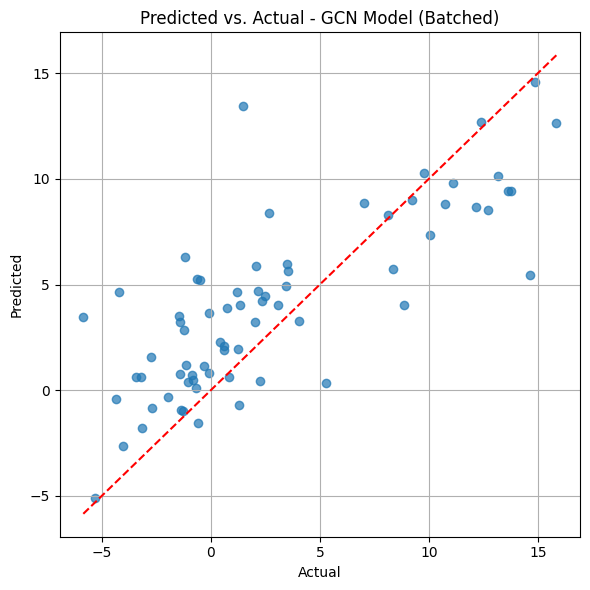

In [92]:
train_gcn_model_batched(train_loader, model_2L, lr=1e-3, epochs=300)
plot_predictions(train_loader, model_2L)

#### 3 Layers

In [93]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel3L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [94]:
model_3L = GCNModel3L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_3L)

GCNModel3L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [95]:
train_gcn_model_batched(train_loader, model_3L, epochs=300, lr=1e-3)

Epoch 1, Loss: 122.6759
Epoch 2, Loss: 115.1380
Epoch 3, Loss: 135.8647
Epoch 4, Loss: 97.1871
Epoch 5, Loss: 107.0885
Epoch 6, Loss: 125.2503
Epoch 7, Loss: 134.0263
Epoch 8, Loss: 107.8163
Epoch 9, Loss: 116.7331
Epoch 10, Loss: 111.5969
Epoch 11, Loss: 74.0549
Epoch 12, Loss: 113.8550
Epoch 13, Loss: 89.5158
Epoch 14, Loss: 106.2102
Epoch 15, Loss: 105.4399
Epoch 16, Loss: 88.1833
Epoch 17, Loss: 88.1923
Epoch 18, Loss: 78.2719
Epoch 19, Loss: 88.7482
Epoch 20, Loss: 86.0849
Epoch 21, Loss: 76.8317
Epoch 22, Loss: 93.9188
Epoch 23, Loss: 77.7609
Epoch 24, Loss: 73.1373
Epoch 25, Loss: 91.8032
Epoch 26, Loss: 110.9548
Epoch 27, Loss: 96.9090
Epoch 28, Loss: 105.5197
Epoch 29, Loss: 86.6168
Epoch 30, Loss: 83.4780
Epoch 31, Loss: 85.7864
Epoch 32, Loss: 82.4862
Epoch 33, Loss: 114.5189
Epoch 34, Loss: 76.0576
Epoch 35, Loss: 88.1480
Epoch 36, Loss: 79.6312
Epoch 37, Loss: 81.5391
Epoch 38, Loss: 72.8280
Epoch 39, Loss: 76.7950
Epoch 40, Loss: 69.6851
Epoch 41, Loss: 79.9362
Epoch 42, 

GCNModel3L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

R² score: 0.645
RMSE: 3.375


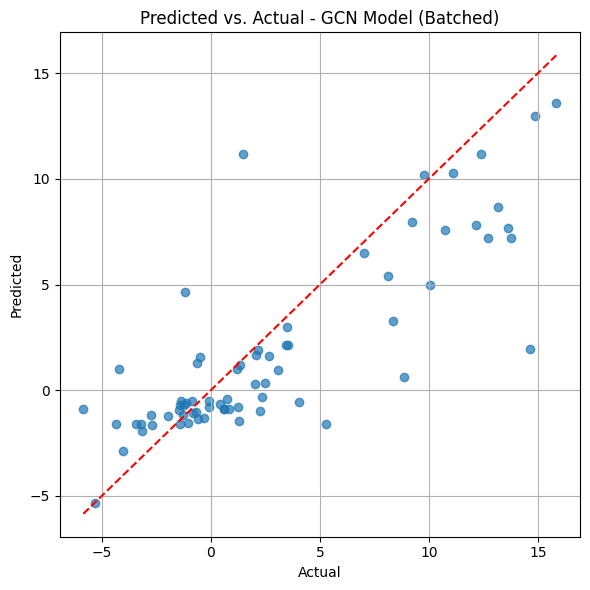

In [96]:
plot_predictions(train_loader, model_3L)

### Number of Epochs

In [30]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    return r2, rmse
    # Plot
    # plt.figure(figsize=(6, 6))
    # plt.scatter(all_targets, all_preds, alpha=0.7)
    # plt.plot([all_targets.min(), all_targets.max()],
    #          [all_targets.min(), all_targets.max()], 'r--')
    # plt.xlabel("Actual")
    # plt.ylabel("Predicted")
    # plt.title("Predicted vs. Actual - GCN Model (Batched)")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

In [86]:
epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in [100, 200, 300, 400, 500]:
    model3 = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gcn_model_batched(train_loader, model3, epochs=epoch, lr=1e-3)
    metrics_epoch[epoch] = r2_rmse(train_loader, model3)
metrics_epoch

Epoch 1, Loss: 112.9980
Epoch 2, Loss: 113.3243
Epoch 3, Loss: 104.9199
Epoch 4, Loss: 107.8771
Epoch 5, Loss: 176.1074
Epoch 6, Loss: 99.4269
Epoch 7, Loss: 107.2852
Epoch 8, Loss: 94.2065
Epoch 9, Loss: 133.8929
Epoch 10, Loss: 136.6344
Epoch 11, Loss: 82.9060
Epoch 12, Loss: 106.4589
Epoch 13, Loss: 126.5997
Epoch 14, Loss: 76.0414
Epoch 15, Loss: 107.1154
Epoch 16, Loss: 106.3758
Epoch 17, Loss: 108.1188
Epoch 18, Loss: 84.8988
Epoch 19, Loss: 124.5415
Epoch 20, Loss: 95.6249
Epoch 21, Loss: 94.4075
Epoch 22, Loss: 94.7896
Epoch 23, Loss: 104.0056
Epoch 24, Loss: 102.1219
Epoch 25, Loss: 99.5299
Epoch 26, Loss: 92.8689
Epoch 27, Loss: 102.2194
Epoch 28, Loss: 92.0818
Epoch 29, Loss: 79.9790
Epoch 30, Loss: 72.8587
Epoch 31, Loss: 89.5319
Epoch 32, Loss: 88.6145
Epoch 33, Loss: 102.7784
Epoch 34, Loss: 92.3530
Epoch 35, Loss: 68.8654
Epoch 36, Loss: 100.2459
Epoch 37, Loss: 113.0404
Epoch 38, Loss: 74.3211
Epoch 39, Loss: 87.9598
Epoch 40, Loss: 91.8276
Epoch 41, Loss: 88.6437
Epoch

{100: (0.3536972999572754, np.float64(4.552350395044597)),
 200: (0.46468329429626465, np.float64(4.143078347111917)),
 300: (0.5479220151901245, np.float64(3.8073640843439116)),
 400: (0.5815058946609497, np.float64(3.663214807117308)),
 500: (0.609704315662384, np.float64(3.53764789932618))}

In [87]:
for key, value in metrics_epoch.items():
    print(f"Epochs: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epochs: 100, R²: 0.354, RMSE: 4.552
Epochs: 200, R²: 0.465, RMSE: 4.143
Epochs: 300, R²: 0.548, RMSE: 3.807
Epochs: 400, R²: 0.582, RMSE: 3.663
Epochs: 500, R²: 0.610, RMSE: 3.538


In [38]:
graph_list[0].y

tensor([5.2900])

In [ ]:
# Exploreing the variance of all Inhibition POwer values in the dataset as a possible source of error
targets = []
for graph in graph_list:
    targets.append(graph.y.item())
np.var(targets)

np.float64(32.06530972525442)

### Learning rate

In [40]:
lrs = [1e-1 ,1e-2 ,1e-3, 1e-4, 1e-5, 1e-6]
obsv_lr_metrics = {}

for lr in lrs:
    model_e3 = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gcn_model_batched(train_loader, model_e3, epochs=300, lr=lr)
    obsv_lr_metrics[lr] = r2_rmse(train_loader, model_e3)
    print(f"Learning Rate: {lr}, R²: {obsv_lr_metrics[lr][0]:.3f}, RMSE: {obsv_lr_metrics[lr][1]:.3f}")

Epoch 1, Loss: 162.1955
Epoch 2, Loss: 111.0296
Epoch 3, Loss: 113.4456
Epoch 4, Loss: 79.1968
Epoch 5, Loss: 120.1758
Epoch 6, Loss: 102.8902
Epoch 7, Loss: 98.7233
Epoch 8, Loss: 116.6175
Epoch 9, Loss: 72.6320
Epoch 10, Loss: 90.1140
Epoch 11, Loss: 79.8403
Epoch 12, Loss: 97.0372
Epoch 13, Loss: 85.8435
Epoch 14, Loss: 86.7774
Epoch 15, Loss: 62.4408
Epoch 16, Loss: 68.5494
Epoch 17, Loss: 76.9024
Epoch 18, Loss: 68.2282
Epoch 19, Loss: 65.9093
Epoch 20, Loss: 98.4948
Epoch 21, Loss: 70.4078
Epoch 22, Loss: 55.1638
Epoch 23, Loss: 51.0243
Epoch 24, Loss: 72.7262
Epoch 25, Loss: 55.4073
Epoch 26, Loss: 66.7765
Epoch 27, Loss: 73.5600
Epoch 28, Loss: 56.5061
Epoch 29, Loss: 42.6003
Epoch 30, Loss: 61.7524
Epoch 31, Loss: 50.1011
Epoch 32, Loss: 77.1552
Epoch 33, Loss: 78.8106
Epoch 34, Loss: 61.2345
Epoch 35, Loss: 58.6493
Epoch 36, Loss: 57.5989
Epoch 37, Loss: 65.1253
Epoch 38, Loss: 97.0880
Epoch 39, Loss: 79.5359
Epoch 40, Loss: 60.4763
Epoch 41, Loss: 75.5360
Epoch 42, Loss: 59.

In [41]:
obsv_lr_metrics

{0.1: (0.543597936630249, np.float64(3.8255291292305316)),
 0.01: (0.75168776512146, np.float64(2.8217384347578096)),
 0.001: (0.5593689680099487, np.float64(3.7588523647322885)),
 0.0001: (0.08462482690811157, np.float64(5.417728828558148)),
 1e-05: (-0.24627768993377686, np.float64(6.321572309065225)),
 1e-06: (-0.2534741163253784, np.float64(6.33979771962264))}

### Dropout Rate

In [42]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
obsv_dropout_metrics = {}

for dr in dropout_rates:
    model_dr = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_gcn_model_batched(train_loader, model_dr, epochs=300, lr=1e-3)
    obsv_dropout_metrics[dr] = r2_rmse(train_loader, model_dr)


Epoch 1, Loss: 126.4715
Epoch 2, Loss: 119.6137
Epoch 3, Loss: 112.6432
Epoch 4, Loss: 105.6701
Epoch 5, Loss: 101.3644
Epoch 6, Loss: 102.1042
Epoch 7, Loss: 87.2622
Epoch 8, Loss: 109.7195
Epoch 9, Loss: 127.1197
Epoch 10, Loss: 98.9429
Epoch 11, Loss: 96.5636
Epoch 12, Loss: 101.9919
Epoch 13, Loss: 102.1105
Epoch 14, Loss: 77.0905
Epoch 15, Loss: 104.2891
Epoch 16, Loss: 99.8558
Epoch 17, Loss: 79.0951
Epoch 18, Loss: 82.0835
Epoch 19, Loss: 87.8609
Epoch 20, Loss: 81.8138
Epoch 21, Loss: 98.5428
Epoch 22, Loss: 90.5260
Epoch 23, Loss: 112.4471
Epoch 24, Loss: 85.6481
Epoch 25, Loss: 77.4120
Epoch 26, Loss: 78.8124
Epoch 27, Loss: 93.6334
Epoch 28, Loss: 99.8761
Epoch 29, Loss: 84.4481
Epoch 30, Loss: 117.7646
Epoch 31, Loss: 94.6953
Epoch 32, Loss: 103.6523
Epoch 33, Loss: 93.9515
Epoch 34, Loss: 114.9661
Epoch 35, Loss: 75.1552
Epoch 36, Loss: 80.2756
Epoch 37, Loss: 95.0925
Epoch 38, Loss: 96.6952
Epoch 39, Loss: 79.9385
Epoch 40, Loss: 84.1883
Epoch 41, Loss: 95.3682
Epoch 42, 

In [43]:
obsv_dropout_metrics

{0.1: (0.565475344657898, np.float64(3.7327158286669193)),
 0.2: (0.5323675274848938, np.float64(3.8723092119712854)),
 0.3: (0.5332300066947937, np.float64(3.8687366195718482)),
 0.4: (0.5233021378517151, np.float64(3.9096630597122455)),
 0.5: (0.5399666428565979, np.float64(3.840717887531127))}